# **Prepare Datasets**

## AWS configuration

In [ ]:
!pip install awscli

In [ ]:
!aws configure

In [3]:
!mkdir -p datasets/test models/unet/ models/evaluation preprocess utils ensemble

## Download train dataset

In [ ]:
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_3band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_8band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz datasets/

In [ ]:
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_3band.tar.gz -C datasets/
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_8band.tar.gz -C datasets/
!tar -xvzf datasets/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz -C datasets/

In [ ]:
# Use for clean up
!rm -rf datasets/3band
!rm -rf datasets/8band
!rm -rf datasets/geojson

## Download test dataset

In [ ]:
# Test images
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_test_AOI_1_Rio_3band.tar.gz datasets/
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_test_AOI_1_Rio_8band.tar.gz datasets/

In [ ]:
!tar -xvzf datasets/SN1_buildings_test_AOI_1_Rio_3band.tar.gz -C datasets/test/
!tar -xvzf datasets/SN1_buildings_test_AOI_1_Rio_8band.tar.gz -C datasets/test/

## Checking train dataset

In [6]:
import os
from os.path import join

In [7]:
image_3b = "datasets/3band"
image_8b = "datasets/8band"
geojson = "datasets/geojson"
print(len([name for name in os.listdir(image_3b)]), "3b images")
print(len([name for name in os.listdir(image_8b)]), "8b images")
print(len([name for name in os.listdir(geojson)]), "geojson labels")

6940 3b images
6940 8b images
6940 geojson labels


## Preprocess

In [ ]:
!pip install rasterio

### Split train dataset to train set and val set

In [ ]:
from preprocess.SplitDataset import SplitDataset

target_dir = "/content/train/"
os.makedirs(target_dir, exist_ok=True)
SplitDataset(
    data_dir="/content/datasets",
    target_dir=target_dir
)

### Create ground truth images

In [88]:
!rm -rf /content/train/train/mask
!rm -rf /content/train/val/mask

In [90]:
from preprocess.CreateMask import Create_Masks_For_Dataset
from preprocess.CreateMaskRasterio import convert_geojsons_to_masks
folders = ["train", "val"]

for folder in folders:
  source_dir = os.path.join(target_dir, folder, "3band")
  geojson_dir = os.path.join(target_dir, folder, "geojson")
  mask_dir = os.path.join(target_dir, folder, "mask")
  # Create_Masks_For_Dataset(source_dir, geojson_dir, mask_dir)
  convert_geojsons_to_masks(geojson_dir, source_dir, mask_dir)

Creating masks: 100%|██████████| 1041/1041 [00:11<00:00, 88.68it/s] 


In [91]:
folders = ["train", "val"]
subfolders = ["3band", "8band", "geojson", "mask"]

for folder in folders:
    for subfolder in subfolders:
        folder_path = os.path.join(target_dir, folder, subfolder)
        print(len([name for name in os.listdir(folder_path)]), folder + "/" + subfolder)

5899 train/3band
5899 train/8band
5899 train/geojson
5899 train/mask
1041 val/3band
1041 val/8band
1041 val/geojson
1041 val/mask


In [30]:
import importlib
import preprocess.CreateMask
importlib.reload(preprocess.CreateMask )

<module 'preprocess.CreateMask' from '/content/preprocess/CreateMask.py'>

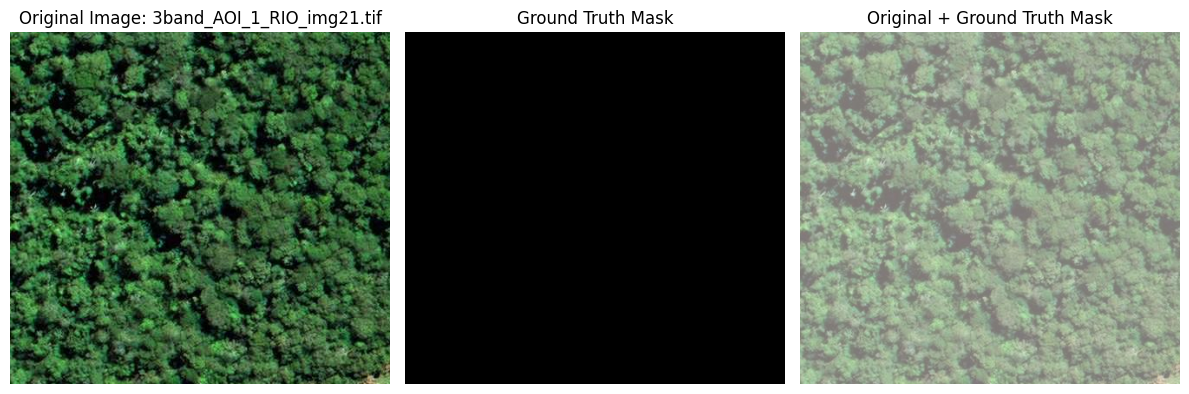

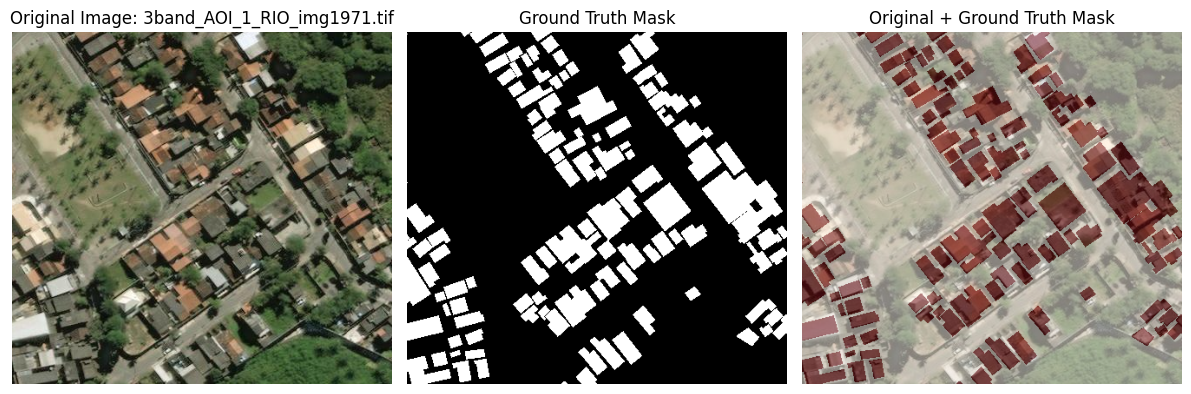

In [92]:
from utils.Visualize import show_random_image_mask_pairs
show_random_image_mask_pairs(
    image_dir="/content/train/train/3band",
    mask_dir="/content/train/train/mask",
    num_samples=2
)

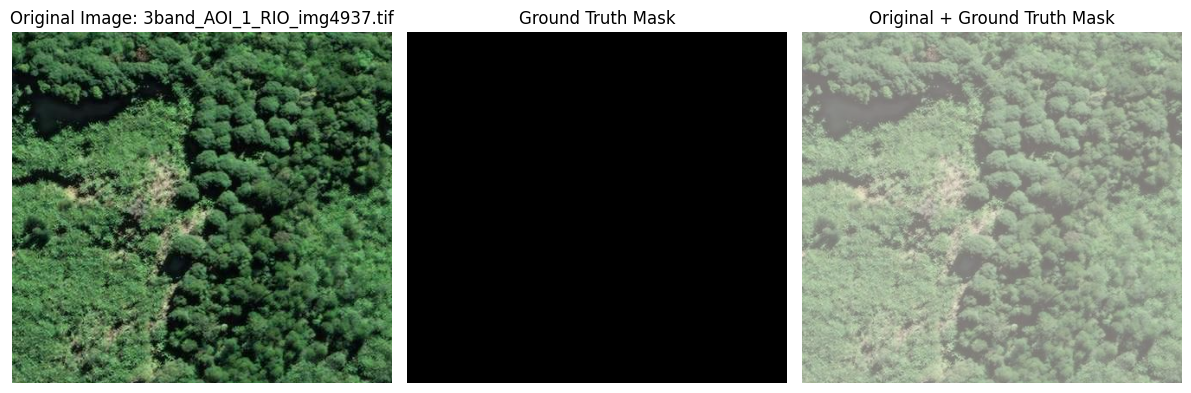

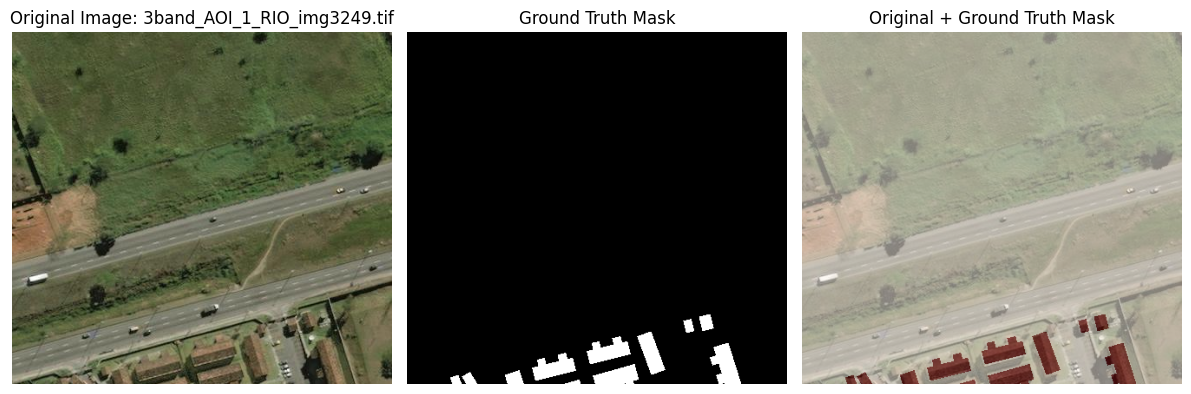

In [93]:
show_random_image_mask_pairs(
    image_dir="/content/train/val/3band",
    mask_dir="/content/train/val/mask",
    num_samples=2
)

## Training

In [101]:
import importlib
import models.CreateDataLoaders
import models.CreateDataset
import preprocess.SplitDataset
import DiceBCELoss
importlib.reload(models.CreateDataLoaders)
importlib.reload(models.CreateDataset)
importlib.reload(DiceBCELoss)
# importlib.reload(preprocess.SplitDataset)

<module 'DiceBCELoss' from '/content/DiceBCELoss.py'>

In [102]:
from models.CreateDataLoaders import CreateDataLoaders
train_loader, val_loader = CreateDataLoaders(128, 128, target_dir, batch_size=32, num_workers=4)
print(train_loader)
print(val_loader)

Found 5899 valid image-mask pairs
Found 1041 valid image-mask pairs


In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# Initialize model
from models.unet.model import UNet
model = UNet(num_classes=1, in_channels=3, depth=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device: ", device)
model = model.to(device)

In [103]:
from DiceBCELoss import DiceBCELoss
criterion = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [82]:
checkpoint_path = "checkpoint.pth"
model_path = '/content/building_segmentation_model_3band_128_29-5.pth'

In [97]:
start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1  # resume from next epoch
    print(f"[✓] Loaded checkpoint from epoch {start_epoch}")
else:
    print("[INFO] No checkpoint found. Training from scratch.")

[INFO] No checkpoint found. Training from scratch.


In [107]:
from tqdm import tqdm
from models.evaluation.evaluation import dice_coef, iou_score, f1_score

num_epochs = 100
history = {
    "train_loss": [],
    "val_loss": [],
    "dice": [],
    "iou": [],
    "f1": [],
    "accuracy": []
}

for epoch in range(start_epoch, num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_acc = 0

    loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.sigmoid(outputs) > 0.5
        acc = (pred == masks).float().mean()

        train_loss += loss.item()
        train_acc += acc.item()

        loop.set_postfix({
            "loss": loss.item(),
            "acc": acc.item()
        })

    # Validation phase
    model.eval()
    val_loss = 0
    total_dice = 0
    total_iou = 0
    total_f1 = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            preds = preds.float()
            targets = masks.float()

            total_dice += dice_coef(preds, targets)
            total_iou += iou_score(preds, targets)
            total_f1 += f1_score(preds, targets)

    avg_train_acc = train_acc / len(train_loader)
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_dice = total_dice / len(val_loader)
    avg_iou = total_iou / len(val_loader)
    avg_f1 = total_f1 / len(val_loader)

    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["dice"].append(avg_dice.item())  # convert from tensor to float
    history["iou"].append(avg_iou.item())
    history["f1"].append(avg_f1.item())
    history["accuracy"].append(avg_train_acc)

    # Print metrics
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
        f"Val Loss: {avg_val_loss:.4f}, Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}, F1: {avg_f1:.4f}")

    # Update learning rate based on validation losp
    scheduler.step(val_loss)

Epoch 1/100: 100%|██████████| 185/185 [00:09<00:00, 19.66it/s, loss=0.544, acc=0.955]


Epoch 1/100, Train Loss: 0.5201, Val Loss: 0.5262, Dice: 0.6633, IoU: 0.4973, F1: 0.6633


Epoch 2/100: 100%|██████████| 185/185 [00:09<00:00, 20.02it/s, loss=0.411, acc=0.953]


Epoch 2/100, Train Loss: 0.5165, Val Loss: 0.5076, Dice: 0.6815, IoU: 0.5179, F1: 0.6815


Epoch 3/100: 100%|██████████| 185/185 [00:09<00:00, 19.99it/s, loss=0.616, acc=0.945]


Epoch 3/100, Train Loss: 0.5140, Val Loss: 0.5129, Dice: 0.6794, IoU: 0.5155, F1: 0.6794


Epoch 4/100: 100%|██████████| 185/185 [00:09<00:00, 19.96it/s, loss=0.533, acc=0.918]


Epoch 4/100, Train Loss: 0.5150, Val Loss: 0.5030, Dice: 0.6824, IoU: 0.5188, F1: 0.6824


Epoch 5/100: 100%|██████████| 185/185 [00:09<00:00, 20.00it/s, loss=0.41, acc=0.942]


Epoch 5/100, Train Loss: 0.5102, Val Loss: 0.5045, Dice: 0.6829, IoU: 0.5195, F1: 0.6829


Epoch 6/100: 100%|██████████| 185/185 [00:09<00:00, 19.99it/s, loss=0.628, acc=0.894]


Epoch 6/100, Train Loss: 0.5099, Val Loss: 0.5020, Dice: 0.6824, IoU: 0.5188, F1: 0.6824


Epoch 7/100: 100%|██████████| 185/185 [00:09<00:00, 20.02it/s, loss=0.405, acc=0.962]


Epoch 7/100, Train Loss: 0.5086, Val Loss: 0.5057, Dice: 0.6795, IoU: 0.5155, F1: 0.6795


Epoch 8/100: 100%|██████████| 185/185 [00:09<00:00, 20.01it/s, loss=0.675, acc=0.946]


Epoch 8/100, Train Loss: 0.5079, Val Loss: 0.5069, Dice: 0.6797, IoU: 0.5158, F1: 0.6797


Epoch 9/100: 100%|██████████| 185/185 [00:09<00:00, 19.81it/s, loss=0.589, acc=0.97]


Epoch 9/100, Train Loss: 0.5027, Val Loss: 0.5178, Dice: 0.6677, IoU: 0.5022, F1: 0.6677


Epoch 10/100: 100%|██████████| 185/185 [00:09<00:00, 19.93it/s, loss=0.501, acc=0.938]


Epoch 10/100, Train Loss: 0.5013, Val Loss: 0.5085, Dice: 0.6815, IoU: 0.5180, F1: 0.6815


Epoch 11/100: 100%|██████████| 185/185 [00:09<00:00, 20.00it/s, loss=0.501, acc=0.968]


Epoch 11/100, Train Loss: 0.5047, Val Loss: 0.4998, Dice: 0.6844, IoU: 0.5212, F1: 0.6844


Epoch 12/100: 100%|██████████| 185/185 [00:09<00:00, 19.99it/s, loss=0.499, acc=0.942]


Epoch 12/100, Train Loss: 0.5024, Val Loss: 0.5125, Dice: 0.6835, IoU: 0.5202, F1: 0.6835


Epoch 13/100: 100%|██████████| 185/185 [00:09<00:00, 20.00it/s, loss=0.315, acc=0.957]


Epoch 13/100, Train Loss: 0.4989, Val Loss: 0.4983, Dice: 0.6863, IoU: 0.5235, F1: 0.6863


Epoch 14/100: 100%|██████████| 185/185 [00:09<00:00, 20.04it/s, loss=0.411, acc=0.972]


Epoch 14/100, Train Loss: 0.4999, Val Loss: 0.4971, Dice: 0.6864, IoU: 0.5235, F1: 0.6864


Epoch 15/100: 100%|██████████| 185/185 [00:09<00:00, 20.00it/s, loss=0.429, acc=0.967]


Epoch 15/100, Train Loss: 0.4965, Val Loss: 0.5032, Dice: 0.6863, IoU: 0.5234, F1: 0.6863


Epoch 16/100: 100%|██████████| 185/185 [00:09<00:00, 19.97it/s, loss=0.449, acc=0.962]


Epoch 16/100, Train Loss: 0.4941, Val Loss: 0.4916, Dice: 0.6901, IoU: 0.5277, F1: 0.6901


Epoch 17/100: 100%|██████████| 185/185 [00:09<00:00, 19.96it/s, loss=0.504, acc=0.959]


Epoch 17/100, Train Loss: 0.4954, Val Loss: 0.5103, Dice: 0.6857, IoU: 0.5227, F1: 0.6857


Epoch 18/100: 100%|██████████| 185/185 [00:09<00:00, 19.92it/s, loss=0.46, acc=0.969]


Epoch 18/100, Train Loss: 0.4971, Val Loss: 0.4856, Dice: 0.6943, IoU: 0.5328, F1: 0.6943


Epoch 19/100: 100%|██████████| 185/185 [00:09<00:00, 19.90it/s, loss=0.502, acc=0.938]


Epoch 19/100, Train Loss: 0.4942, Val Loss: 0.5108, Dice: 0.6734, IoU: 0.5086, F1: 0.6734


Epoch 20/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.51, acc=0.933]


Epoch 20/100, Train Loss: 0.4877, Val Loss: 0.5023, Dice: 0.6872, IoU: 0.5246, F1: 0.6872


Epoch 21/100: 100%|██████████| 185/185 [00:09<00:00, 19.88it/s, loss=0.434, acc=0.957]


Epoch 21/100, Train Loss: 0.4912, Val Loss: 0.4840, Dice: 0.6938, IoU: 0.5320, F1: 0.6938


Epoch 22/100: 100%|██████████| 185/185 [00:09<00:00, 19.94it/s, loss=0.536, acc=0.919]


Epoch 22/100, Train Loss: 0.4892, Val Loss: 0.4939, Dice: 0.6895, IoU: 0.5272, F1: 0.6895


Epoch 23/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.469, acc=0.931]


Epoch 23/100, Train Loss: 0.4888, Val Loss: 0.4939, Dice: 0.6905, IoU: 0.5283, F1: 0.6905


Epoch 24/100: 100%|██████████| 185/185 [00:09<00:00, 19.78it/s, loss=0.533, acc=0.923]


Epoch 24/100, Train Loss: 0.4888, Val Loss: 0.4949, Dice: 0.6854, IoU: 0.5224, F1: 0.6854


Epoch 25/100: 100%|██████████| 185/185 [00:09<00:00, 19.79it/s, loss=0.452, acc=0.963]


Epoch 25/100, Train Loss: 0.4842, Val Loss: 0.4845, Dice: 0.6919, IoU: 0.5300, F1: 0.6919


Epoch 26/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.47, acc=0.958]


Epoch 26/100, Train Loss: 0.4838, Val Loss: 0.4845, Dice: 0.6955, IoU: 0.5341, F1: 0.6955


Epoch 27/100: 100%|██████████| 185/185 [00:09<00:00, 19.90it/s, loss=0.385, acc=0.96]


Epoch 27/100, Train Loss: 0.4893, Val Loss: 0.4765, Dice: 0.6979, IoU: 0.5369, F1: 0.6979


Epoch 28/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.429, acc=0.943]


Epoch 28/100, Train Loss: 0.4844, Val Loss: 0.4817, Dice: 0.6989, IoU: 0.5381, F1: 0.6989


Epoch 29/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.387, acc=0.964]


Epoch 29/100, Train Loss: 0.4812, Val Loss: 0.4883, Dice: 0.6894, IoU: 0.5268, F1: 0.6894


Epoch 30/100: 100%|██████████| 185/185 [00:09<00:00, 19.89it/s, loss=0.494, acc=0.983]


Epoch 30/100, Train Loss: 0.4839, Val Loss: 0.4885, Dice: 0.6899, IoU: 0.5275, F1: 0.6899


Epoch 31/100: 100%|██████████| 185/185 [00:09<00:00, 19.89it/s, loss=0.7, acc=0.902]


Epoch 31/100, Train Loss: 0.4855, Val Loss: 0.4715, Dice: 0.7051, IoU: 0.5455, F1: 0.7051


Epoch 32/100: 100%|██████████| 185/185 [00:09<00:00, 19.88it/s, loss=0.428, acc=0.964]


Epoch 32/100, Train Loss: 0.4787, Val Loss: 0.4773, Dice: 0.7004, IoU: 0.5400, F1: 0.7004


Epoch 33/100: 100%|██████████| 185/185 [00:09<00:00, 19.87it/s, loss=0.536, acc=0.926]


Epoch 33/100, Train Loss: 0.4795, Val Loss: 0.4831, Dice: 0.6990, IoU: 0.5382, F1: 0.6990


Epoch 34/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.503, acc=0.958]


Epoch 34/100, Train Loss: 0.4769, Val Loss: 0.4762, Dice: 0.7008, IoU: 0.5403, F1: 0.7008


Epoch 35/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.528, acc=0.933]


Epoch 35/100, Train Loss: 0.4783, Val Loss: 0.4803, Dice: 0.6963, IoU: 0.5350, F1: 0.6963


Epoch 36/100: 100%|██████████| 185/185 [00:09<00:00, 19.87it/s, loss=0.439, acc=0.93]


Epoch 36/100, Train Loss: 0.4761, Val Loss: 0.4769, Dice: 0.7012, IoU: 0.5408, F1: 0.7012


Epoch 37/100: 100%|██████████| 185/185 [00:09<00:00, 19.86it/s, loss=0.541, acc=0.923]


Epoch 37/100, Train Loss: 0.4759, Val Loss: 0.4780, Dice: 0.7016, IoU: 0.5414, F1: 0.7016


Epoch 38/100: 100%|██████████| 185/185 [00:09<00:00, 19.95it/s, loss=0.497, acc=0.934]


Epoch 38/100, Train Loss: 0.4674, Val Loss: 0.4680, Dice: 0.7051, IoU: 0.5454, F1: 0.7051


Epoch 39/100: 100%|██████████| 185/185 [00:09<00:00, 19.93it/s, loss=0.463, acc=0.939]


Epoch 39/100, Train Loss: 0.4664, Val Loss: 0.4768, Dice: 0.6963, IoU: 0.5350, F1: 0.6963


Epoch 40/100: 100%|██████████| 185/185 [00:09<00:00, 19.92it/s, loss=0.495, acc=0.944]


Epoch 40/100, Train Loss: 0.4663, Val Loss: 0.4678, Dice: 0.7048, IoU: 0.5450, F1: 0.7048


Epoch 41/100: 100%|██████████| 185/185 [00:09<00:00, 19.90it/s, loss=0.543, acc=0.904]


Epoch 41/100, Train Loss: 0.4646, Val Loss: 0.4648, Dice: 0.7071, IoU: 0.5478, F1: 0.7071


Epoch 42/100: 100%|██████████| 185/185 [00:09<00:00, 19.93it/s, loss=0.394, acc=0.958]


Epoch 42/100, Train Loss: 0.4647, Val Loss: 0.4741, Dice: 0.6984, IoU: 0.5374, F1: 0.6984


Epoch 43/100: 100%|██████████| 185/185 [00:09<00:00, 19.86it/s, loss=0.441, acc=0.97]


Epoch 43/100, Train Loss: 0.4634, Val Loss: 0.4686, Dice: 0.7045, IoU: 0.5448, F1: 0.7045


Epoch 44/100: 100%|██████████| 185/185 [00:09<00:00, 19.88it/s, loss=0.322, acc=0.966]


Epoch 44/100, Train Loss: 0.4638, Val Loss: 0.4666, Dice: 0.7068, IoU: 0.5476, F1: 0.7068


Epoch 45/100: 100%|██████████| 185/185 [00:09<00:00, 19.88it/s, loss=0.618, acc=0.896]


Epoch 45/100, Train Loss: 0.4654, Val Loss: 0.4653, Dice: 0.7080, IoU: 0.5489, F1: 0.7080


Epoch 46/100: 100%|██████████| 185/185 [00:09<00:00, 19.90it/s, loss=0.421, acc=0.968]


Epoch 46/100, Train Loss: 0.4639, Val Loss: 0.4641, Dice: 0.7072, IoU: 0.5479, F1: 0.7072


Epoch 47/100: 100%|██████████| 185/185 [00:09<00:00, 19.90it/s, loss=0.48, acc=0.937]


Epoch 47/100, Train Loss: 0.4617, Val Loss: 0.4639, Dice: 0.7078, IoU: 0.5487, F1: 0.7078


Epoch 48/100: 100%|██████████| 185/185 [00:09<00:00, 19.88it/s, loss=0.449, acc=0.943]


Epoch 48/100, Train Loss: 0.4611, Val Loss: 0.4657, Dice: 0.7069, IoU: 0.5476, F1: 0.7069


Epoch 49/100: 100%|██████████| 185/185 [00:09<00:00, 19.92it/s, loss=0.446, acc=0.949]


Epoch 49/100, Train Loss: 0.4601, Val Loss: 0.4633, Dice: 0.7088, IoU: 0.5499, F1: 0.7088


Epoch 50/100: 100%|██████████| 185/185 [00:09<00:00, 19.88it/s, loss=0.434, acc=0.962]


Epoch 50/100, Train Loss: 0.4610, Val Loss: 0.4649, Dice: 0.7083, IoU: 0.5494, F1: 0.7083


Epoch 51/100: 100%|██████████| 185/185 [00:09<00:00, 19.88it/s, loss=0.338, acc=0.978]


Epoch 51/100, Train Loss: 0.4596, Val Loss: 0.4728, Dice: 0.7002, IoU: 0.5396, F1: 0.7002


Epoch 52/100: 100%|██████████| 185/185 [00:09<00:00, 19.90it/s, loss=0.495, acc=0.942]


Epoch 52/100, Train Loss: 0.4588, Val Loss: 0.4608, Dice: 0.7086, IoU: 0.5497, F1: 0.7086


Epoch 53/100: 100%|██████████| 185/185 [00:09<00:00, 19.92it/s, loss=0.255, acc=0.977]


Epoch 53/100, Train Loss: 0.4593, Val Loss: 0.4686, Dice: 0.7041, IoU: 0.5443, F1: 0.7041


Epoch 54/100: 100%|██████████| 185/185 [00:09<00:00, 19.95it/s, loss=0.451, acc=0.98]


Epoch 54/100, Train Loss: 0.4603, Val Loss: 0.4657, Dice: 0.7081, IoU: 0.5491, F1: 0.7081


Epoch 55/100: 100%|██████████| 185/185 [00:09<00:00, 19.94it/s, loss=0.319, acc=0.987]


Epoch 55/100, Train Loss: 0.4580, Val Loss: 0.4589, Dice: 0.7089, IoU: 0.5499, F1: 0.7089


Epoch 56/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.469, acc=0.957]


Epoch 56/100, Train Loss: 0.4580, Val Loss: 0.4616, Dice: 0.7082, IoU: 0.5491, F1: 0.7082


Epoch 57/100: 100%|██████████| 185/185 [00:09<00:00, 19.90it/s, loss=0.42, acc=0.963]


Epoch 57/100, Train Loss: 0.4563, Val Loss: 0.4596, Dice: 0.7112, IoU: 0.5528, F1: 0.7112


Epoch 58/100: 100%|██████████| 185/185 [00:09<00:00, 19.72it/s, loss=0.473, acc=0.937]


Epoch 58/100, Train Loss: 0.4587, Val Loss: 0.4561, Dice: 0.7128, IoU: 0.5547, F1: 0.7128


Epoch 59/100: 100%|██████████| 185/185 [00:09<00:00, 19.80it/s, loss=0.48, acc=0.964]


Epoch 59/100, Train Loss: 0.4554, Val Loss: 0.4636, Dice: 0.7057, IoU: 0.5461, F1: 0.7057


Epoch 60/100: 100%|██████████| 185/185 [00:09<00:00, 19.84it/s, loss=0.474, acc=0.922]


Epoch 60/100, Train Loss: 0.4565, Val Loss: 0.4650, Dice: 0.7047, IoU: 0.5449, F1: 0.7047


Epoch 61/100: 100%|██████████| 185/185 [00:09<00:00, 19.83it/s, loss=0.397, acc=0.967]


Epoch 61/100, Train Loss: 0.4555, Val Loss: 0.4561, Dice: 0.7128, IoU: 0.5546, F1: 0.7128


Epoch 62/100: 100%|██████████| 185/185 [00:09<00:00, 19.87it/s, loss=0.491, acc=0.933]


Epoch 62/100, Train Loss: 0.4540, Val Loss: 0.4583, Dice: 0.7095, IoU: 0.5507, F1: 0.7095


Epoch 63/100: 100%|██████████| 185/185 [00:09<00:00, 19.83it/s, loss=0.458, acc=0.937]


Epoch 63/100, Train Loss: 0.4542, Val Loss: 0.4624, Dice: 0.7084, IoU: 0.5493, F1: 0.7084


Epoch 64/100: 100%|██████████| 185/185 [00:09<00:00, 19.92it/s, loss=0.376, acc=0.972]


Epoch 64/100, Train Loss: 0.4540, Val Loss: 0.4613, Dice: 0.7091, IoU: 0.5503, F1: 0.7091


Epoch 65/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.463, acc=0.965]


Epoch 65/100, Train Loss: 0.4504, Val Loss: 0.4525, Dice: 0.7157, IoU: 0.5581, F1: 0.7157


Epoch 66/100: 100%|██████████| 185/185 [00:09<00:00, 19.88it/s, loss=0.423, acc=0.955]


Epoch 66/100, Train Loss: 0.4479, Val Loss: 0.4545, Dice: 0.7117, IoU: 0.5532, F1: 0.7117


Epoch 67/100: 100%|██████████| 185/185 [00:09<00:00, 19.92it/s, loss=0.439, acc=0.982]


Epoch 67/100, Train Loss: 0.4517, Val Loss: 0.4527, Dice: 0.7147, IoU: 0.5569, F1: 0.7147


Epoch 68/100: 100%|██████████| 185/185 [00:09<00:00, 19.84it/s, loss=0.433, acc=0.963]


Epoch 68/100, Train Loss: 0.4491, Val Loss: 0.4556, Dice: 0.7115, IoU: 0.5531, F1: 0.7115


Epoch 69/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.365, acc=0.963]


Epoch 69/100, Train Loss: 0.4472, Val Loss: 0.4512, Dice: 0.7157, IoU: 0.5582, F1: 0.7157


Epoch 70/100: 100%|██████████| 185/185 [00:09<00:00, 19.97it/s, loss=0.369, acc=0.957]


Epoch 70/100, Train Loss: 0.4488, Val Loss: 0.4528, Dice: 0.7146, IoU: 0.5567, F1: 0.7146


Epoch 71/100: 100%|██████████| 185/185 [00:09<00:00, 19.94it/s, loss=0.447, acc=0.946]


Epoch 71/100, Train Loss: 0.4485, Val Loss: 0.4526, Dice: 0.7145, IoU: 0.5567, F1: 0.7145


Epoch 72/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.526, acc=0.913]


Epoch 72/100, Train Loss: 0.4454, Val Loss: 0.4552, Dice: 0.7136, IoU: 0.5556, F1: 0.7136


Epoch 73/100: 100%|██████████| 185/185 [00:09<00:00, 19.82it/s, loss=0.471, acc=0.925]


Epoch 73/100, Train Loss: 0.4477, Val Loss: 0.4565, Dice: 0.7121, IoU: 0.5538, F1: 0.7121


Epoch 74/100: 100%|██████████| 185/185 [00:09<00:00, 19.88it/s, loss=0.551, acc=0.911]


Epoch 74/100, Train Loss: 0.4467, Val Loss: 0.4578, Dice: 0.7122, IoU: 0.5541, F1: 0.7122


Epoch 75/100: 100%|██████████| 185/185 [00:09<00:00, 19.83it/s, loss=0.542, acc=0.899]


Epoch 75/100, Train Loss: 0.4475, Val Loss: 0.4549, Dice: 0.7121, IoU: 0.5537, F1: 0.7121


Epoch 76/100: 100%|██████████| 185/185 [00:09<00:00, 19.88it/s, loss=0.451, acc=0.96]


Epoch 76/100, Train Loss: 0.4446, Val Loss: 0.4529, Dice: 0.7132, IoU: 0.5551, F1: 0.7132


Epoch 77/100: 100%|██████████| 185/185 [00:09<00:00, 19.89it/s, loss=0.412, acc=0.962]


Epoch 77/100, Train Loss: 0.4432, Val Loss: 0.4506, Dice: 0.7163, IoU: 0.5589, F1: 0.7163


Epoch 78/100: 100%|██████████| 185/185 [00:09<00:00, 19.68it/s, loss=0.362, acc=0.948]


Epoch 78/100, Train Loss: 0.4433, Val Loss: 0.4509, Dice: 0.7161, IoU: 0.5586, F1: 0.7161


Epoch 79/100: 100%|██████████| 185/185 [00:09<00:00, 19.90it/s, loss=0.64, acc=0.874]


Epoch 79/100, Train Loss: 0.4428, Val Loss: 0.4513, Dice: 0.7156, IoU: 0.5580, F1: 0.7156


Epoch 80/100: 100%|██████████| 185/185 [00:09<00:00, 19.93it/s, loss=0.429, acc=0.981]


Epoch 80/100, Train Loss: 0.4458, Val Loss: 0.4506, Dice: 0.7155, IoU: 0.5578, F1: 0.7155


Epoch 81/100: 100%|██████████| 185/185 [00:09<00:00, 19.90it/s, loss=0.42, acc=0.945]


Epoch 81/100, Train Loss: 0.4434, Val Loss: 0.4532, Dice: 0.7126, IoU: 0.5543, F1: 0.7126


Epoch 82/100: 100%|██████████| 185/185 [00:09<00:00, 19.90it/s, loss=0.423, acc=0.981]


Epoch 82/100, Train Loss: 0.4432, Val Loss: 0.4489, Dice: 0.7171, IoU: 0.5598, F1: 0.7171


Epoch 83/100: 100%|██████████| 185/185 [00:09<00:00, 19.90it/s, loss=0.445, acc=0.942]


Epoch 83/100, Train Loss: 0.4432, Val Loss: 0.4504, Dice: 0.7142, IoU: 0.5563, F1: 0.7142


Epoch 84/100: 100%|██████████| 185/185 [00:09<00:00, 19.94it/s, loss=0.448, acc=0.949]


Epoch 84/100, Train Loss: 0.4420, Val Loss: 0.4494, Dice: 0.7162, IoU: 0.5587, F1: 0.7162


Epoch 85/100: 100%|██████████| 185/185 [00:09<00:00, 19.86it/s, loss=0.566, acc=0.923]


Epoch 85/100, Train Loss: 0.4435, Val Loss: 0.4534, Dice: 0.7141, IoU: 0.5563, F1: 0.7141


Epoch 86/100: 100%|██████████| 185/185 [00:09<00:00, 19.96it/s, loss=0.539, acc=0.909]


Epoch 86/100, Train Loss: 0.4426, Val Loss: 0.4492, Dice: 0.7164, IoU: 0.5589, F1: 0.7164


Epoch 87/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.436, acc=0.942]


Epoch 87/100, Train Loss: 0.4427, Val Loss: 0.4473, Dice: 0.7179, IoU: 0.5609, F1: 0.7179


Epoch 88/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.392, acc=0.961]


Epoch 88/100, Train Loss: 0.4423, Val Loss: 0.4481, Dice: 0.7166, IoU: 0.5592, F1: 0.7166


Epoch 89/100: 100%|██████████| 185/185 [00:09<00:00, 19.85it/s, loss=0.471, acc=0.94]


Epoch 89/100, Train Loss: 0.4426, Val Loss: 0.4476, Dice: 0.7182, IoU: 0.5612, F1: 0.7182


Epoch 90/100: 100%|██████████| 185/185 [00:09<00:00, 19.80it/s, loss=0.362, acc=0.954]


Epoch 90/100, Train Loss: 0.4411, Val Loss: 0.4519, Dice: 0.7139, IoU: 0.5560, F1: 0.7139


Epoch 91/100: 100%|██████████| 185/185 [00:09<00:00, 19.84it/s, loss=0.421, acc=0.973]


Epoch 91/100, Train Loss: 0.4416, Val Loss: 0.4482, Dice: 0.7170, IoU: 0.5597, F1: 0.7170


Epoch 92/100: 100%|██████████| 185/185 [00:09<00:00, 19.80it/s, loss=0.488, acc=0.931]


Epoch 92/100, Train Loss: 0.4417, Val Loss: 0.4500, Dice: 0.7149, IoU: 0.5572, F1: 0.7149


Epoch 93/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.504, acc=0.938]


Epoch 93/100, Train Loss: 0.4415, Val Loss: 0.4485, Dice: 0.7171, IoU: 0.5597, F1: 0.7171


Epoch 94/100: 100%|██████████| 185/185 [00:09<00:00, 19.77it/s, loss=0.493, acc=0.945]


Epoch 94/100, Train Loss: 0.4405, Val Loss: 0.4495, Dice: 0.7163, IoU: 0.5588, F1: 0.7163


Epoch 95/100: 100%|██████████| 185/185 [00:09<00:00, 19.92it/s, loss=0.414, acc=0.934]


Epoch 95/100, Train Loss: 0.4409, Val Loss: 0.4470, Dice: 0.7180, IoU: 0.5609, F1: 0.7180


Epoch 96/100: 100%|██████████| 185/185 [00:09<00:00, 19.83it/s, loss=0.498, acc=0.951]


Epoch 96/100, Train Loss: 0.4409, Val Loss: 0.4476, Dice: 0.7172, IoU: 0.5599, F1: 0.7172


Epoch 97/100: 100%|██████████| 185/185 [00:09<00:00, 19.84it/s, loss=0.196, acc=0.978]


Epoch 97/100, Train Loss: 0.4389, Val Loss: 0.4466, Dice: 0.7181, IoU: 0.5610, F1: 0.7181


Epoch 98/100: 100%|██████████| 185/185 [00:09<00:00, 19.91it/s, loss=0.272, acc=0.978]


Epoch 98/100, Train Loss: 0.4392, Val Loss: 0.4454, Dice: 0.7186, IoU: 0.5616, F1: 0.7186


Epoch 99/100: 100%|██████████| 185/185 [00:09<00:00, 19.89it/s, loss=0.46, acc=0.963]


Epoch 99/100, Train Loss: 0.4395, Val Loss: 0.4485, Dice: 0.7165, IoU: 0.5590, F1: 0.7165


Epoch 100/100: 100%|██████████| 185/185 [00:09<00:00, 19.85it/s, loss=0.362, acc=0.973]


Epoch 100/100, Train Loss: 0.4395, Val Loss: 0.4472, Dice: 0.7169, IoU: 0.5596, F1: 0.7169


In [ ]:
import importlib
import models.CreateDataLoaders
import models.CreateDataset
import preprocess.SplitDataset
importlib.reload(models.CreateDataLoaders)

In [31]:
# Save checkpoint after each epoch
torch.save({
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'history': history
}, checkpoint_path)

In [108]:
torch.save(model.state_dict(), model_path)

In [ ]:
# Clean up
del model, train_loader, val_loader, outputs, loss
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
import gc
gc.collect()

302

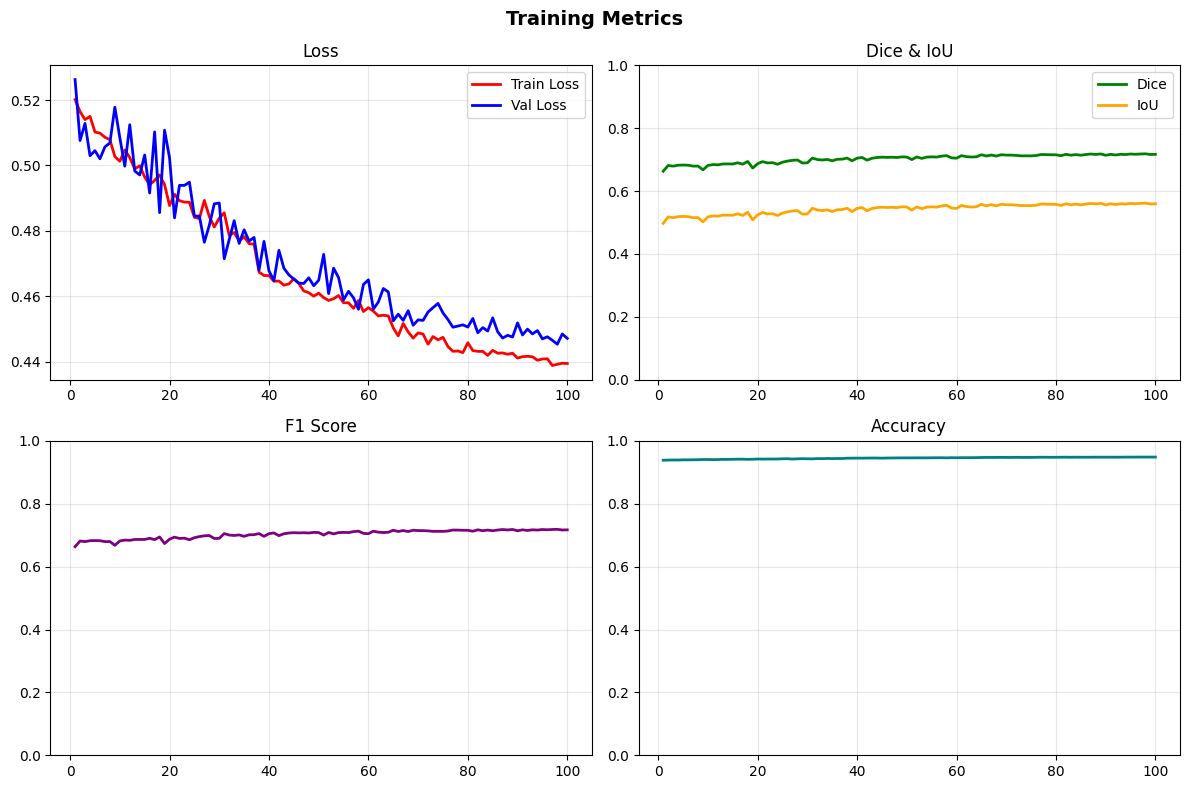

In [119]:
from utils.Visualize import visualize_metrics_compact
visualize_metrics_compact(history, save_path="unet_128_29-5_training_metrics.png")

# **Test U-Net model**

In [ ]:
from models.unet.model import UNet
import torch

# Create the model with the same config as during training
model = UNet(num_classes=1, in_channels=3, depth=5)

if os.path.exists(checkpoint_path):
  checkpoint = torch.load(checkpoint_path, map_location=device)
  model.load_state_dict(checkpoint["model_state_dict"])
else:
  model.load_state_dict(torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

In [117]:
import importlib
import utils.Utilities
import utils.Visualize
importlib.reload(utils.Utilities)
importlib.reload(utils.Visualize)

<module 'utils.Visualize' from '/content/utils/Visualize.py'>

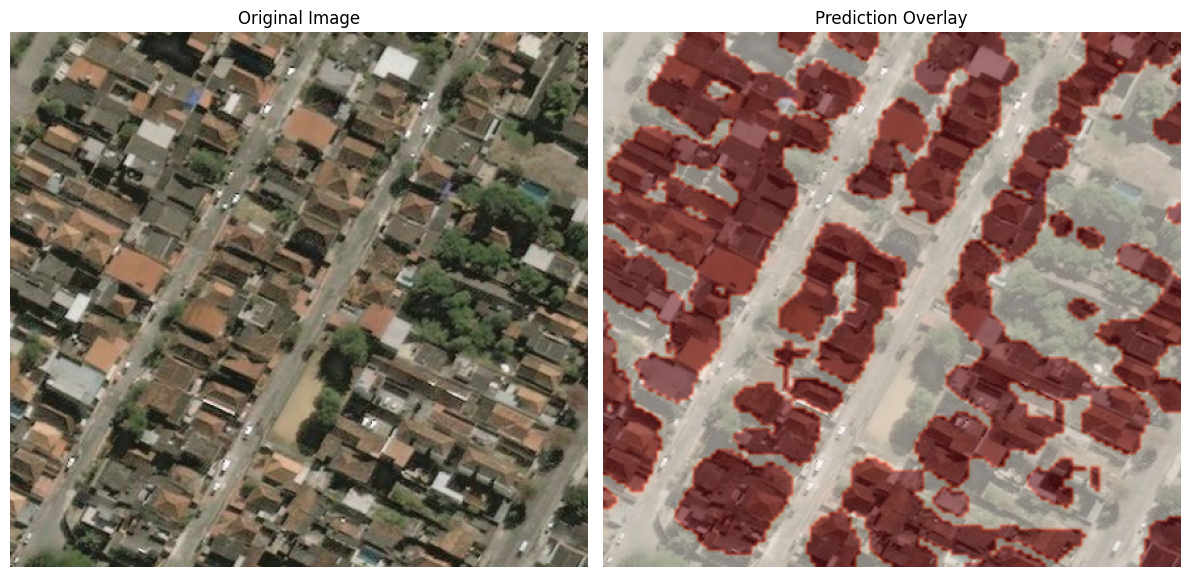

In [121]:
from utils.Utilities import predict
import utils.Visualize as vs

image_path = "/content/datasets/test/3band/3band_AOI_2_RIO_img1067.tif"
prediction = predict(model, image_path, 128, 128)

vs.visualizeOriginalWithMask(image_path, prediction)

# **Ensemble with SAM**

## Installing SAM and download checkpoint

In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Init SAM model

In [44]:
sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("DEVICE:", DEVICE)

DEVICE: cuda:0


In [45]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(DEVICE)
predictor = SamPredictor(sam)

## Fusion U-Net and SAM masks

### Install PyDenseCRF

In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

### Testing

In [57]:
model_128_path = "/content/building_segmentation_model_3band_128_29-5.pth"

In [ ]:
from models.unet.model import UNet
import torch

model_128 = UNet(num_classes=1, in_channels=3, depth=5)
model_128.load_state_dict(torch.load(model_path, map_location="cuda" if torch.cuda.is_available() else "cpu"))

model_128.eval()
model_128.to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import importlib
import utils.Visualize
importlib.reload(utils.Visualize)

<module 'utils.Visualize' from '/content/utils/Visualize.py'>

In [49]:
from utils.Utilities import predict, save_prediction_as_png
from preprocess.CreateMaskRasterio import create_sam_mask
from ensemble.fusion import fusion
import cv2
from utils.Visualize import visualize_with_multiple_masks

## Testcase #1: img1120

In [50]:
!mkdir -p /content/test/img1120
!cp /content/datasets/test/3band/3band_AOI_2_RIO_img1120.tif /content/test/img1120/img1120.tif

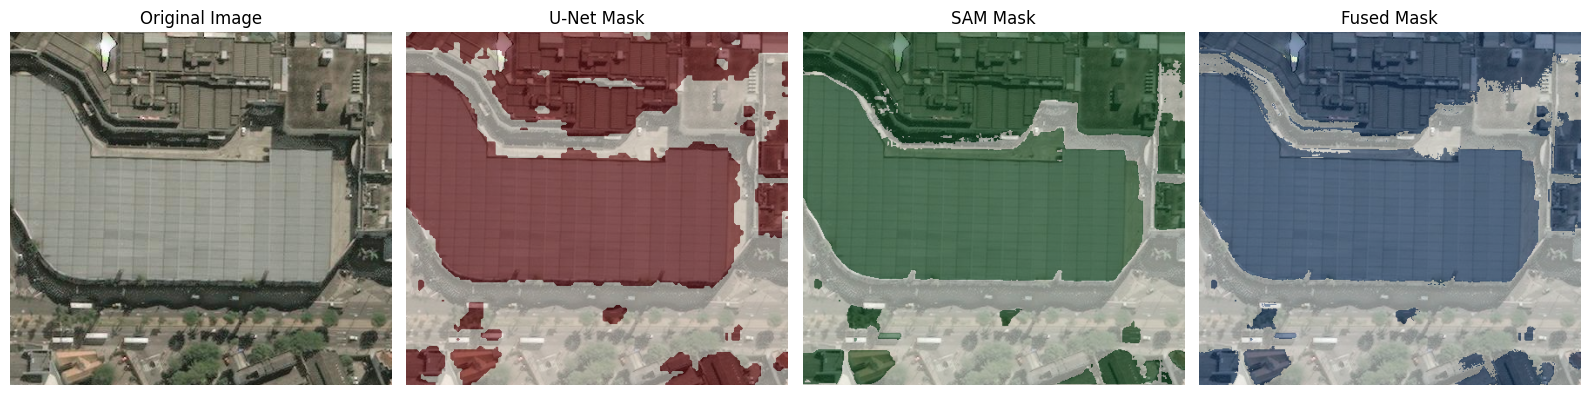

In [123]:
basename = "img1120"

# Create U-Net mask
image_path = f"/content/test/{basename}/{basename}.tif"
output128_dir = f"/content/test/{basename}/model128/"
unet128_mask = output128_dir + f"unet_{basename}.png"

os.makedirs(output128_dir, exist_ok=True)
prediction_128 = predict(model_128, image_path, 128, 128)
save_prediction_as_png(prediction_128, unet128_mask)

# Create SAM mask
sam128_mask = output128_dir + f"sam_{basename}.png"
create_sam_mask(predictor, image_path, unet128_mask, sam128_mask)

# Fusion U-Net mask and SAM mask
fusion(image_path, unet128_mask, sam128_mask, output128_dir)

# Visualize
unet_mask = cv2.imread(f"/content/test/{basename}/model128/unet_{basename}.png", cv2.IMREAD_GRAYSCALE)
sam_mask = cv2.imread(f"/content/test/{basename}/model128/sam_{basename}.png", cv2.IMREAD_GRAYSCALE)
fused_mask = cv2.imread(f"/content/test/{basename}/model128/crf_unet_{basename}.png", cv2.IMREAD_GRAYSCALE)

mask1 = (unet_mask, "U-Net Mask")
mask2 = (sam_mask, "SAM Mask")
mask3 = (fused_mask, "Fused Mask")

save_path = os.path.join(output128_dir, f"result_{basename}.png")

visualize_with_multiple_masks(image_path, mask1, mask2, mask3, save_path)

## Testcase #2: img1568

In [52]:
!mkdir -p /content/test/img1568
!cp /content/datasets/test/3band/3band_AOI_2_RIO_img1568.tif /content/test/img1568/img1568.tif

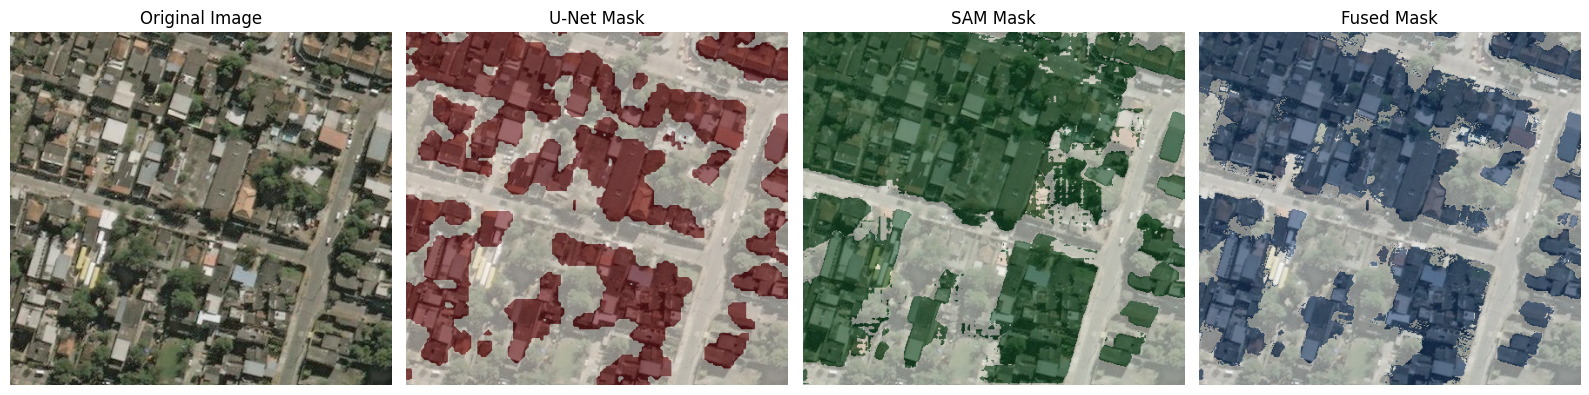

In [125]:
basename = "img1568"

# Create U-Net mask
image_path = f"/content/test/{basename}/{basename}.tif"
output128_dir = f"/content/test/{basename}/model128/"
unet128_mask = output128_dir + f"unet_{basename}.png"

os.makedirs(output128_dir, exist_ok=True)
prediction_128 = predict(model_128, image_path, 128, 128)
save_prediction_as_png(prediction_128, unet128_mask)

# Create SAM mask
sam128_mask = output128_dir + f"sam_{basename}.png"
create_sam_mask(predictor, image_path, unet128_mask, sam128_mask)

# Fusion U-Net mask and SAM mask
fusion(image_path, unet128_mask, sam128_mask, output128_dir)

# Visualize
unet_mask = cv2.imread(f"/content/test/{basename}/model128/unet_{basename}.png", cv2.IMREAD_GRAYSCALE)
sam_mask = cv2.imread(f"/content/test/{basename}/model128/sam_{basename}.png", cv2.IMREAD_GRAYSCALE)
fused_mask = cv2.imread(f"/content/test/{basename}/model128/crf_unet_{basename}.png", cv2.IMREAD_GRAYSCALE)

mask1 = (unet_mask, "U-Net Mask")
mask2 = (sam_mask, "SAM Mask")
mask3 = (fused_mask, "Fused Mask")

save_path = os.path.join(output128_dir, f"result_{basename}.png")

visualize_with_multiple_masks(image_path, mask1, mask2, mask3, save_path)